In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import emoji as em
import torch
import tqdm
import spacy
import json

from spacy.tokenizer import Tokenizer

from spacy.lang.en import English

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

from transformers import AutoTokenizer, AdamW, get_linear_schedule_with_warmup, AutoModelForSequenceClassification

import warnings

warnings.filterwarnings('ignore')

import logging

logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [2]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
train_dataset_path = "/content/drive/MyDrive/dataset/SemEval2018-T3-train-taskA_emoji.txt"
test_dataset_path = "/content/drive/MyDrive/dataset/SemEval2018-T3_gold_test_taskA_emoji.txt"
smileys_path  = "/content/drive/MyDrive/dataset/emoticons.json"

In [4]:
train_df = pd.read_csv(train_dataset_path, sep="\t")
train_df.rename(columns={"Tweet index": "index", "Label": "label", "Tweet text": "text"},
                inplace=True)

test_df = pd.read_csv(train_dataset_path, sep="\t")
test_df.rename(columns={"Tweet index": "index", "Label": "label", "Tweet text": "text"},
               inplace=True)
test_df.head()

,index,label,text
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...


Text(0.5, 0, 'length')

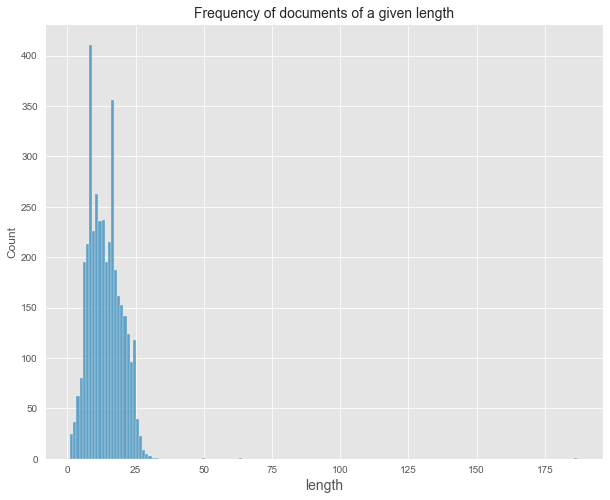

In [5]:
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
train_df["length"] = train_df["text"].apply(lambda x: len(x.split()))
sns.histplot(train_df["length"])
plt.title("Frequency of documents of a given length", fontsize=14)
plt.xlabel("length", fontsize=14)

In [ ]:
def load_dict(filepath):
    """Loads dict from json file"""
    file = open(filepath, "r", encoding="utf8")
    loaded_dict = file.read()
    return json.loads(loaded_dict)

tokenizer = Tokenizer(English().vocab)
smiley_dict = load_dict(smileys_path)

def preprocess(text):
    new_text = []
    l = tokenizer(text)
    for t_n in l:
        t = t_n.text
        if '@' in t and len(t) > 1:
            t = '@user'
        elif 'http' in t.lower():
            t = 'http'
        elif t in smiley_dict:
            t = smiley_dict[t]
        t = em.demojize(t, delimiters=("", ""))
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
train_df["text"] = train_df["text"].apply(lambda x: preprocess(x))
test_df["text"] = test_df["text"].apply(lambda x: preprocess(x))

In [6]:
class SarcasticSentenceDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        if len(sentences) != len(labels):
            raise ValueError("Sentences and labels should have the same number of elements.")

        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index: int):
        inputs = self.tokenizer(self.sentences[index],
                                truncation=True,
                                pad_to_max_length=True,
                                return_tensors="pt",
                                max_length=self.max_len)

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[index], dtype=torch.long)
        }

    def __len__(self):
        return len(self.sentences)

In [7]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
train_dataset = SarcasticSentenceDataset(sentences=train_df["text"].tolist(),
                                         labels=train_df["label"].tolist(),
                                         tokenizer=tokenizer)

test_dataset = SarcasticSentenceDataset(sentences=test_df["text"].tolist(),
                                        labels=test_df["label"].tolist(),
                                        tokenizer=tokenizer)

In [8]:
item = train_dataset[0]
print(f"sentence: {train_df['text'][0]}\n"
      f"ids: {item['input_ids']}\n"
      f"attention_mask: {item['attention_mask']}\n"
      f"label: {item['labels']}")

sentence: Sweet United Nations video. Just in time for Christmas. #imagine #NoReligion  http://t.co/fej2v3OUBR
ids: tensor([    0, 35942,   315,  3076,   569,     4,  1801,    11,    86,    13,
         1619,     4,   849,   757, 37620,   849,  3084, 29806, 43617,  1437,
         2054,   640,    90,     4,   876,    73,  7068,   267,   176,   705,
          246,  5061,  7202,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     

In [ ]:
import copy


def train(model,
          dataset,
          device,
          lr=5e-5,
          num_epochs=5,
          batch_size=8):
    train_loader, validation_loader = setup_dataset_loaders(dataset, batch_size)

    num_batches = len(dataset) // batch_size
    num_warmup_steps = min(4000, int(0.1 * num_epochs * num_batches))
    num_training_steps = num_batches * num_epochs
    optimizer, scheduler = setup_optimizer_and_scheduler(model,
                                                         lr,
                                                         num_warmup_steps,
                                                         num_training_steps)

    best_f1 = 0
    best_epoch = -1
    best_params = copy.deepcopy(model.state_dict())
    patience = 0

    for epoch in range(num_epochs):
        print(f"epoch: {epoch}")

        train_result = train_epoch(model, optimizer, scheduler, train_loader, device)
        print(f"train loss: {train_result['loss']}\n"
              f"train accuracy: {train_result['accuracy']}\n")

        valid_result = valid_epoch(model, validation_loader, device)
        print(f"valid accuracy: {valid_result['accuracy']}\n"
              f"valid f1: {valid_result['f1']}\n")

        if valid_result["f1"] > best_f1:
            best_f1 = valid_result["f1"]
            best_epoch = epoch
            best_params = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1

        print(f"patience: {patience}\n")
        if patience == 2:
            break

    print(f"best epoch: {best_epoch}\n"
          f"best f1: {best_f1}\n")

    model.load_state_dict(best_params)
    return model


def setup_dataset_loaders(dataset, batch_size):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(0.2 * dataset_size))
    train_indices, val_indices = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=batch_size)
    validation_loader = DataLoader(train_dataset,
                                   sampler=validation_sampler,
                                   batch_size=batch_size)

    return train_loader, validation_loader


def setup_optimizer_and_scheduler(model, lr, num_warmup_steps, num_training_steps):
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=num_warmup_steps,
                                                num_training_steps=num_training_steps)
    return optimizer, scheduler


def train_epoch(model, optimizer, scheduler, loader, device):
    model.train()

    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    total_steps = 0

    for batch in tqdm.tqdm(loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        output = model(input_ids, attention_mask=mask, labels=labels, return_dict=True)
        loss = output.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        _, preds = torch.max(output.logits, dim=1, keepdim=False)
        correct = (labels == preds).sum().item()

        total_steps += 1
        total_examples += input_ids.size()[0]
        total_loss += loss.item()
        total_correct += correct

    return {
        "loss": total_loss / total_steps,
        "accuracy": total_correct / total_examples
    }


def valid_epoch(model, loader, device):
    y_true, y_pred = test(model, loader, device)
    return compute_metrics(y_true, y_pred)


def test(model, loader, device):
    model.eval()

    labels_list = []
    preds_list = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            output = model(input_ids, attention_mask=attention_mask, labels=labels, return_dict=True)
            _, preds = torch.max(output.logits, dim=1, keepdim=False)

            labels_list.extend(labels.cpu().numpy().tolist())
            preds_list.extend(preds.cpu().numpy().tolist())

    return labels_list, preds_list


def compute_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }

In [17]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2).to(device)
model = train(model, train_dataset, device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

epoch: 0


  1%|          | 3/382 [00:34<1:13:38, 11.66s/it]


KeyboardInterrupt: 

In [ ]:
result = valid_epoch(model, DataLoader(test_dataset, batch_size=4), device)
print(f"test accuracy: {result['accuracy']}\n"
      f"test f1: {result['f1']}\n")

torch.save(model.state_dict(), "model.pth")
print("model params saved")